# Лабораторная работа 4

In [377]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from typing import Tuple
import qpsolvers 
from qpsolvers import solve_qp 
from sklearn import svm
import math
from sklearn.inspection import DecisionBoundaryDisplay

In [378]:
def GenerateRandomVectors(meanVector, covarianceMatrix, N, savedFileName=None):
    # Создание матрицы А для получения вектора X
    A = np.zeros((2,2))
    A[0,0] = math.sqrt(covarianceMatrix[0, 0])
    A[1,0] = covarianceMatrix[1, 0] / math.sqrt(covarianceMatrix[0, 0])
    A[1,1] = math.sqrt(covarianceMatrix[1, 1] - covarianceMatrix[0, 1] * covarianceMatrix[0, 1] / covarianceMatrix[0, 0])
    
    # Генерация N двухмерных векторов, каждый элемент из стандартного нормального распределения N(0,1)
    E = np.array([])
    for i in range(N):
        e = np.zeros((2, 1))
        n = 1000
        a = 0
        b = 1
        for i in range(n):
            uni = np.random.uniform(a, b, 2)
            e += uni.reshape(2,1)
        e = (e - n * 0.5) / np.sqrt(n / 12)
        E = np.append(E, e)
    #print(E)
    E = np.reshape(E, [2, N])
    
    # Генерация вектора X с сользованием матрицы МА и корреляционной матрицы
    #x = np.matmul(A, E) + np.repeat(meanVector, N, axis=1)
    x = np.dot(A, E) + meanVector
    
    # np.save(savedFileName, x)
    # if os.path.exists("./vectors/"+savedFileName + ".npy"):
    #     os.remove("./vectors/"+savedFileName + ".npy")
    # shutil.move(savedFileName + ".npy", "./vectors")
    
    
    return x

In [379]:
def CalculateCovarianceMatrix(sigma1, sigma2, rho):
    cov_matrix = np.array([[sigma1**2, rho*sigma1*sigma2],
                       [rho*sigma1*sigma2, sigma2**2]])
    print("Ковариационная матрица: \n", cov_matrix)
    return cov_matrix

In [380]:
def convert_x(x):
    res = []
    for i, j in zip(x[0], x[1]):
        res.append([i, j])
    return np.array(res)

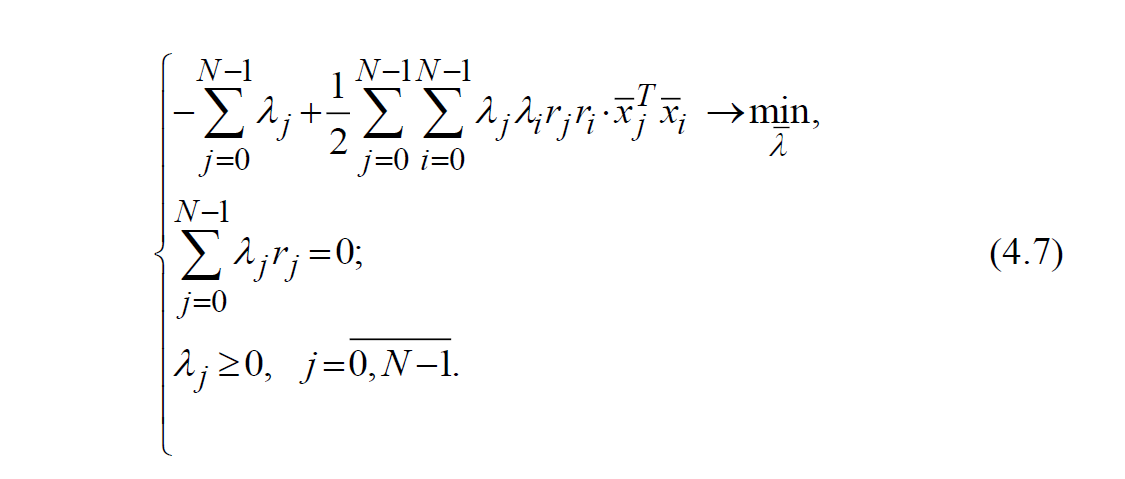

Параметры функции
Обязательные:
P - симметричная положительно полуопределенная матрица размера (n, n)

q - вектор размера (n,)

Ограничения-неравенства (опционально):
G - матрица ограничений-неравенств размера (m, n)

h - вектор правых частей размера (m,)

Ограничения-равенства (опционально):
A - матрица ограничений-равенств размера (p, n)

b - вектор правых частей размера (p,)

In [381]:
def get_support_vectors_razd(X, r, min, max, epsilon = 1e-15):
    """
    Решает задачу SVM (метод опорных векторов) и находит опорные векторы
    
    Параметры:
    X - матрица признаков (каждая строка - один объект)
    r - вектор меток классов (+1 или -1)
    min, max - границы для построения графика
    epsilon - порог для определения опорных векторов
    """
    # K[i,j] = x_i · x_j (скалярное произведение)
    K = np.matmul(X, X.T)                 
    N = len(r)
    
    # Матрица P для квадратичного члена: P[i,j] = r_j * r_i * x_j^T * x_i
    P = np.outer(r, r) * K  
    
    # Вектор q для линейного члена: q = [-1, -1, ..., -1]
    # Соответствует -∑λ_j (минус потому что минимизируем)        
    q = -np.ones(N)   
    # Ограничения-неравенства (λ_j ≥ 0)
    # G * λ ≤ h, где G = -I, h = [0,0,...,0]
    # Это эквивалентно: -λ_j ≤ 0 → λ_j ≥ 0              
    G = -np.eye(N)                  
    h = np.zeros(N)  
    
    # Ограничения-равенства ∑λ_j * r_j = 0
    # A * λ = b, где A = r^T, b = 0
    A = r.reshape(1, -1)            
    b = np.array([0.0])        
         
    # Находим вектор λ (lambda_solve) - двойственные переменные
    lambda_solve = solve_qp(P, q, G, h, A, b, solver='cvxopt')

    # Преобразуем y в одномерный массив для удобства
    r = r.ravel()
    
    # w = ∑(λ_j * y_j * x_j) - линейная комбинация опорных векторов
    w = np.sum((lambda_solve * r)[:, None] * X, axis=0) 


    # Проверяем, что решение найдено
    if lambda_solve is not None:
        sv_idx = lambda_solve > epsilon
        X_sv = X[sv_idx]      # Матрица опорных векторов
        r_sv = r[sv_idx]      # Метки опорных векторов

        # Вычисление смещения (bias) b
        b = 0
        if np.any(sv_idx):
            # Вычисляем w·x для всех опорных векторов
            wx = np.matmul(X_sv, w.T)
            # b = среднее(r_sv - w·x_sv) - из условия для опорных векторов
            b = np.mean(r_sv - wx)
            
        # Даныне для графика
        x = np.linspace(min, max, 500)
        koef_a = -w[0]/w[1]
        koef_b = -b/w[1]
        luft = (1)/w[1]
        
        y_line = koef_a*x + koef_b
        # Верхняя граница зазора: w·x + b = +1
        y_plus  = koef_a*x + koef_b + luft
        # Нижняя граница зазора: w·x + b = -1
        y_minus = koef_a*x + koef_b - luft
    else: 
        return np.array([-1]), np.array([-1]), np.array([-1]), np.array([-1]), -1, -1, -1     

    return x, y_line, y_plus, y_minus, X_sv, r_sv, [koef_a, koef_b, luft]

In [382]:
def find_zero_crossings(x, y):
    """Находит точки пересечения нуля"""
    crossings = []
    for i in range(len(y) - 1):
        if y[i] * y[i + 1] <= 0:  # Знак меняется
            # Линейная интерполяция
            x_cross = x[i] - y[i] * (x[i + 1] - x[i]) / (y[i + 1] - y[i] + 1e-10)
            crossings.append(x_cross)
    return crossings


def find_level_crossings(x, y, level=0):
    """Находит точки пересечения заданного уровня"""
    y_shifted = y - level
    return find_zero_crossings(x, y_shifted)


def interpolate_missing(y):
    """Интерполирует пропущенные значения в массиве"""
    if np.all(np.isnan(y)):
        return y
    
    x_indices = np.arange(len(y))
    valid_mask = ~np.isnan(y)
    
    if np.sum(valid_mask) < 2:
        return y
    
    from scipy.interpolate import interp1d
    interp_func = interp1d(x_indices[valid_mask], y[valid_mask], 
                          kind='linear', bounds_error=False, 
                          fill_value="extrapolate")
    return interp_func(x_indices)

In [383]:
# # Обработка нелинейного ядра
#     else:
#         x = np.linspace(x_min, x_max, n_points)
#         y = np.linspace(x_min, x_max, n_points)
#         xx, yy = np.meshgrid(x, y)
#         grid_points = np.c_[xx.ravel(), yy.ravel()]
        
#         # Получаем значения решающей функции
#         Z = clf.decision_function(grid_points)
#         Z = Z.reshape(xx.shape)
        
#         # Инициализируем массивы для границ
#         x_line = np.linspace(x_min, x_max, n_points)
#         y_line = np.full(n_points, np.nan)
#         y_plus = np.full(n_points, np.nan)
#         y_minus = np.full(n_points, np.nan)
        
#         # Для каждого x находим y, где Z ≈ 0, 1, -1
#         for i, x_val in enumerate(x):
#             # Находим индексы, где x близко к x_val
#             x_idx = np.argmin(np.abs(x - x_val))
            
#             # Ищем пересечения с уровнями
#             z_slice = Z[x_idx, :]
            
#             # Уровень 0 (основная граница)
#             zero_crossings = find_zero_crossings(y, z_slice)
#             if len(zero_crossings) > 0:
#                 y_line[i] = zero_crossings[0]
            
#             # Уровень 1 (верхняя граница)
#             plus_crossings = find_level_crossings(y, z_slice, level=1)
#             if len(plus_crossings) > 0:
#                 y_plus[i] = plus_crossings[0]
            
#             # Уровень -1 (нижняя граница)
#             minus_crossings = find_level_crossings(y, z_slice, level=-1)
#             if len(minus_crossings) > 0:
#                 y_minus[i] = minus_crossings[0]

In [384]:
def get_support_vectors_SVC_universal(X, clf, x_min, x_max, n_points = 500):
    """
    Универсальная версия для линейных и нелинейных ядер
    
    Параметры:
    X - матрица признаков для обучения (если классификатор не обучен)
    clf - объект SVM классификатора из sklearn
    x_min, x_max - границы области для построения графика
    n_points - количество точек для построения линий
    """
    
    # Если у классификатора нет опорных векторов, значит он не обучен
    if not hasattr(clf, 'support_vectors_'):
        # Обучаем классификатор на искусственных метках
        # Создаем метки: первая половина - класс 1, вторая половина - класс -1
        clf.fit(X, np.hstack([np.ones(X.shape[0] // 2), -np.ones(X.shape[0] // 2)]))
    
    # Обработка линейного ядра
    if clf.kernel == 'linear':
        # Для линейного ядра можем явно вычислить параметры гиперплоскости
        w = clf.coef_[0]      # Вектор весов (нормаль к гиперплоскости)
        b = clf.intercept_[0] # Смещение (bias)
        
        x_line = np.linspace(x_min, x_max, n_points)
        
        koef_a = -w[0]/w[1]
        koef_b = -b/w[1]
        luft = (1)/w[1]
        
        y_line = koef_a*x_line + koef_b
        # Верхняя граница зазора: w·x + b = +1
        y_plus  = koef_a*x_line + koef_b + luft
        # Нижняя граница зазора: w·x + b = -1
        y_minus = koef_a*x_line + koef_b - luft
        
        koefs = [koef_a, koef_b, luft]
    # Обработка нелинейного ядра
    else:
        raise ValueError("Ядро нелинейное")
    
    return x_line, y_line, y_plus, y_minus, koefs

In [385]:
def get_support_vectors_LinearSVC(X, clf, min, max):
    """
    Специализированная версия для LinearSVC классификатора
    
    Параметры:
    X - матрица признаков для обучения
    clf - объект LinearSVC классификатора (только линейный!)
    min, max - границы для построения графика
    """
    
    # Создаем сбалансированные метки: первая половина = +1, вторая половина = -1
    N = X.shape[0] // 2  # Половина от общего количества объектов
    y = np.hstack([np.ones(N), -np.ones(N)]).reshape(-1, 1)  # Формируем вектор меток

    # Обучение классификатора
    clf.fit(X, y.ravel())

    # Извлечение параметров модели
    w = np.transpose(clf.coef_)  # Транспонируем веса для удобства вычислений
    b = clf.intercept_[0]        # Смещение (intercept)

    x = np.linspace(min, max, 500)  # Точки по оси X
    
    koef_a = -w[0]/w[1]
    koef_b = -b/w[1]
    luft = (1)/w[1]
    
    y_line = koef_a*x + koef_b
    # Верхняя граница зазора: w·x + b = +1
    y_plus  = koef_a*x + koef_b + luft
    # Нижняя граница зазора: w·x + b = -1
    y_minus = koef_a*x + koef_b - luft
    
    return x, y_line, y_plus, y_minus, [koef_a[0], koef_b[0], luft[0]]

## Пункт 2

Ковариационная матрица: 
 [[1.  0.2]
 [0.2 1. ]]
Ковариационная матрица: 
 [[1.0404  0.20808]
 [0.20808 1.0404 ]]


Text(0.5, 1.0, 'Выборка линейно разделимых векторов X1, X2')

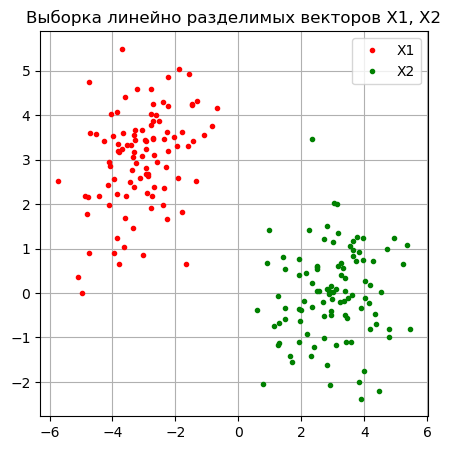

In [386]:
M1 = np.array([[-3],[3]])  # МА вектора 1
M2 = np.array([[3],[0]])  # МА вектора 2

B1 = CalculateCovarianceMatrix(1, 1, 0.2)
B2 = CalculateCovarianceMatrix(1.02, 1.02, 0.2)

N = 100

x1_1 = GenerateRandomVectors(M1, B1, N)
x1_2 = GenerateRandomVectors(M2, B2, N)

xlim_2 = [min(min(x1_1[0]), min(x1_2[0])) - 1, max(max(x1_1[0]), max(x1_2[0])) + 1]

plt.figure(figsize=(5, 5))
plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none')  # plot saved and loaded data
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none')  # plot saved and loaded data
plt.grid(True)
plt.legend(['X1', 'X2'])
plt.title('Выборка линейно разделимых векторов X1, X2')

In [387]:
x_1 = np.concatenate((convert_x(x1_1), convert_x(x1_2)), axis=0) 
y_1 = np.hstack([np.ones(100), -np.ones(100)]).reshape(-1, 1)

x, y, y_plus, y_minus, X_sv, y_sv, koefs = get_support_vectors_razd(x_1, y_1, xlim_2[0], xlim_2[1], epsilon=1e-7)

clf_svc = svm.SVC(kernel="linear")
x_svc, y_svc, y_plus_svc, y_minus_svc, koefs_svc = get_support_vectors_SVC_universal(x_1, clf_svc, xlim_2[0], xlim_2[1])

clf_linear_svc = svm.LinearSVC(dual="auto")
x_linear_svc, y_linear_svc, y_plus_linear_svc, y_minus_linear_svc, koefs_linear_svc = get_support_vectors_LinearSVC(x_1, clf_linear_svc, xlim_2[0], xlim_2[1])

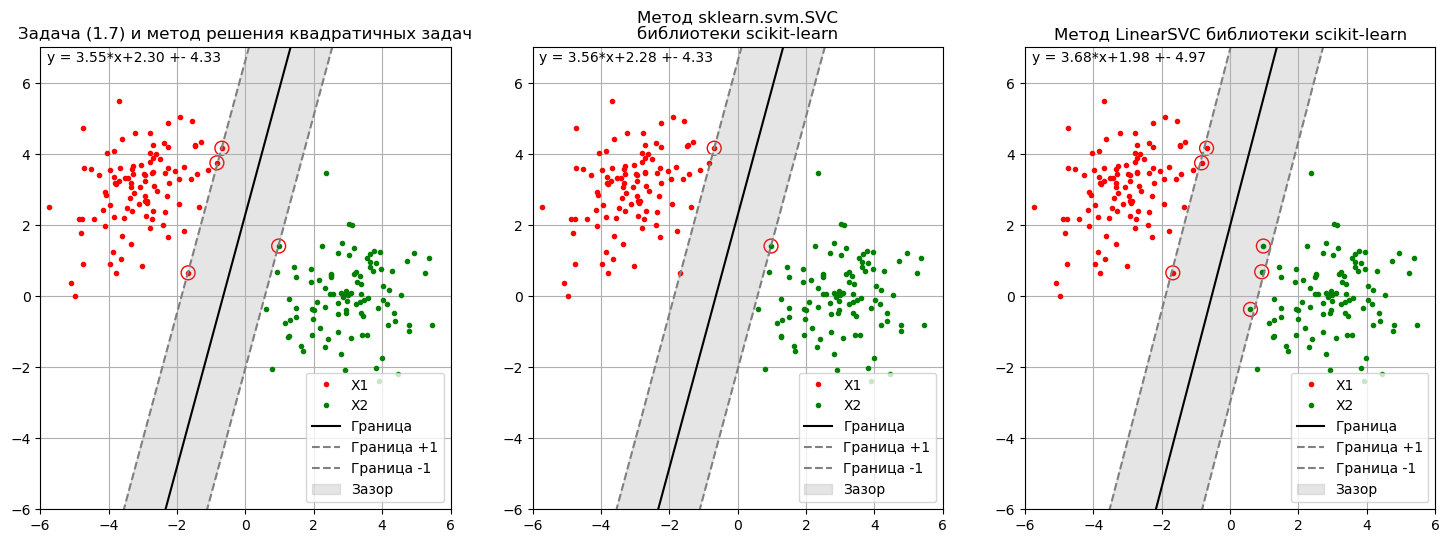

In [388]:
plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.title("Задача (1.7) и метод решения квадратичных задач")
plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none', label='X1')
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none', label='X2')

plt.scatter(X_sv[:,0], X_sv[:,1], s=100, linewidth=1, facecolors="none", edgecolors="r")
plt.plot(x, y, label='Граница', color="black")
plt.plot(x, y_plus, label='Граница +1', color='gray', linestyle="--")
plt.plot(x, y_minus, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x, y_minus, y_plus, color='gray', alpha=0.2, label='Зазор')
plt.grid(True)
plt.xlim(-6, 6)
plt.ylim(-6, 7)
plt.text(-5.8, 6.6, f'y = {koefs[0]:.2f}*x+{koefs[1]:.2f} +- {koefs[2]:.2f}')
plt.legend()


plt.subplot(1,3,2)
plt.title("Метод sklearn.svm.SVC\nбиблиотеки scikit-learn")
plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none', label='X1')
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none', label='X2')
decision_vals = clf_svc.decision_function(x_1)
X_sv_svc_indices = np.where(np.abs(decision_vals) <= 1 + 1e-15)[0]
X_sv_svc = x_1[X_sv_svc_indices]
plt.scatter(X_sv_svc[:, 0], X_sv_svc[:, 1], s=100, linewidth=1, facecolors="none", edgecolors="r")
plt.plot(x_svc, y_svc, label='Граница', color="black")
plt.plot(x_svc, y_plus_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x_svc, y_minus_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x_svc, y_minus_svc, y_plus_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True)
plt.xlim(-6, 6)
plt.ylim(-6, 7)
plt.text(-5.8, 6.6, f'y = {koefs_svc[0]:.2f}*x+{koefs_svc[1]:.2f} +- {koefs_svc[2]:.2f}')
plt.legend()


plt.subplot(1,3,3)
plt.title("Метод LinearSVC библиотеки scikit-learn")
plt.plot(x1_1[0,:], x1_1[1,:], color='red', marker='.', linestyle='none', label='X1')
plt.plot(x1_2[0,:], x1_2[1,:], color='green', marker='.', linestyle='none', label='X2')

decision_vals = clf_linear_svc.decision_function(x_1)
X_sv_svc_indices = np.where(np.abs(decision_vals) <= 1 + 1e-15)[0]
X_sv_svc = x_1[X_sv_svc_indices]
plt.scatter(X_sv_svc[:, 0], X_sv_svc[:, 1], s=100, linewidth=1, facecolors="none", edgecolors="r")
plt.plot(x_linear_svc, y_linear_svc, label='Граница', color="black")
plt.plot(x_linear_svc, y_plus_linear_svc, label='Граница +1', color='gray', linestyle="--")
plt.plot(x_linear_svc, y_minus_linear_svc, label='Граница -1', color='gray', linestyle="--")
plt.fill_between(x_linear_svc, y_minus_linear_svc, y_plus_linear_svc, color='gray', alpha=0.2, label='Зазор')
plt.grid(True)
plt.legend()
plt.xlim(-6, 6)
plt.ylim(-6, 7)
plt.text(-5.8, 6.6, f'y = {koefs_linear_svc[0]:.2f}*x+{koefs_linear_svc[1]:.2f} +- {koefs_linear_svc[2]:.2f}')
plt.show()

## Пункт 3

Ковариационная матрица: 
 [[1.  0.2]
 [0.2 1. ]]
Ковариационная матрица: 
 [[1.0404  0.20808]
 [0.20808 1.0404 ]]


Text(0.5, 1.0, 'Выборка линейно разделимых векторов X1, X2')

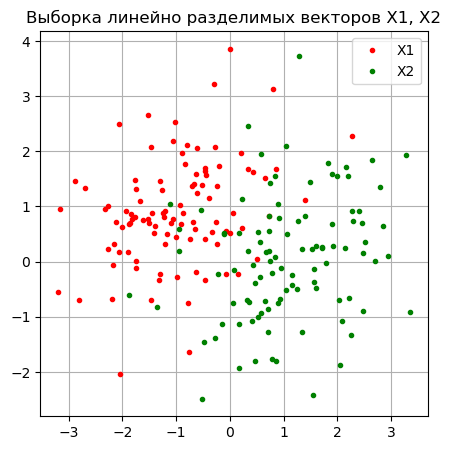

In [389]:
M1 = np.array([[-1],[1]])  # МА вектора 1
M2 = np.array([[1],[0]])  # МА вектора 2

B1 = CalculateCovarianceMatrix(1, 1, 0.2)
B2 = CalculateCovarianceMatrix(1.02, 1.02, 0.2)

N = 100

x2_1 = GenerateRandomVectors(M1, B1, N)
x2_2 = GenerateRandomVectors(M2, B2, N)

xlim_3 = [min(min(x2_1[0]), min(x2_2[0])) - 1, max(max(x2_1[0]), max(x2_2[0])) + 1]

plt.figure(figsize=(5, 5))
plt.plot(x2_1[0,:], x2_1[1,:], color='red', marker='.', linestyle='none')
plt.plot(x2_2[0,:], x2_2[1,:], color='green', marker='.', linestyle='none')
plt.grid(True)
plt.legend(['X1', 'X2'])
plt.title('Выборка линейно разделимых векторов X1, X2')

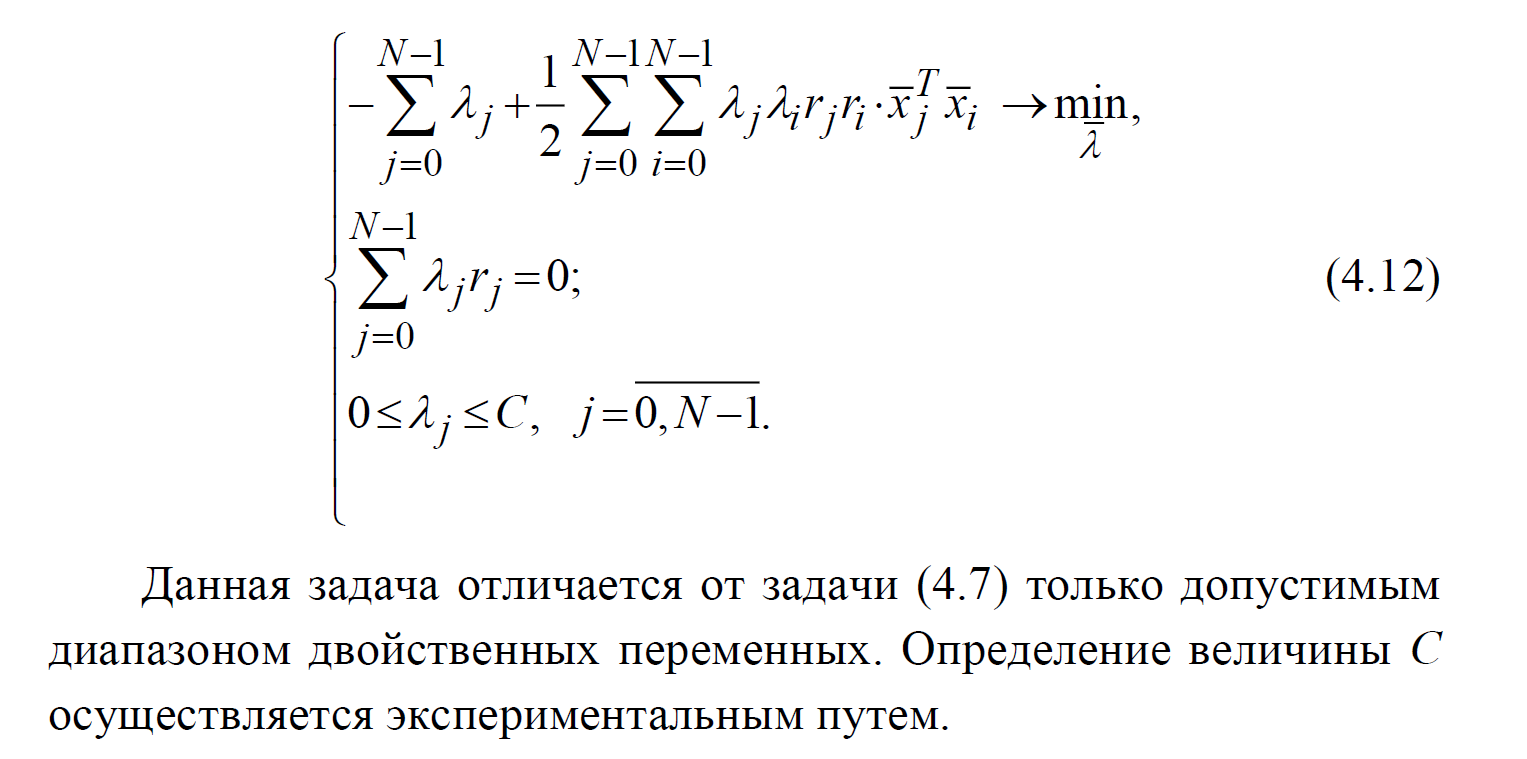

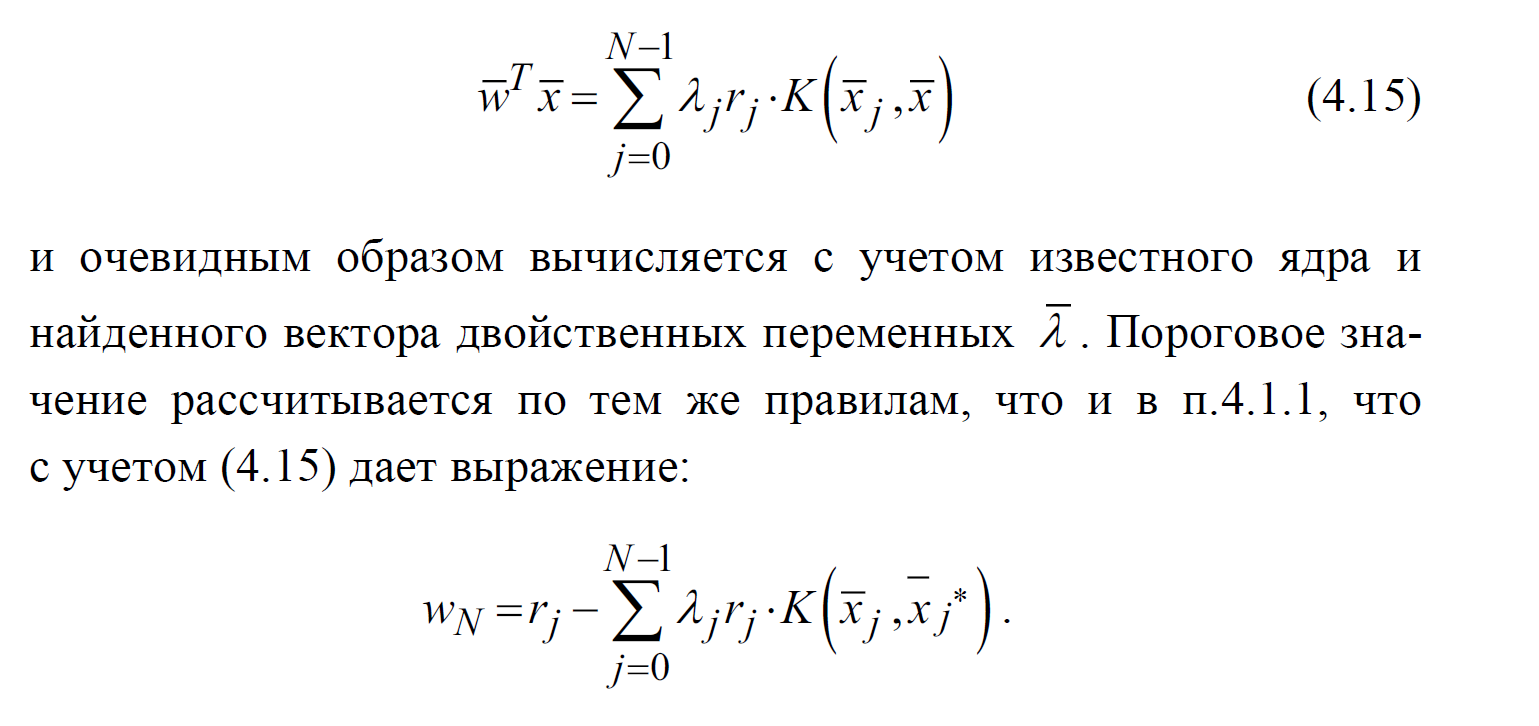

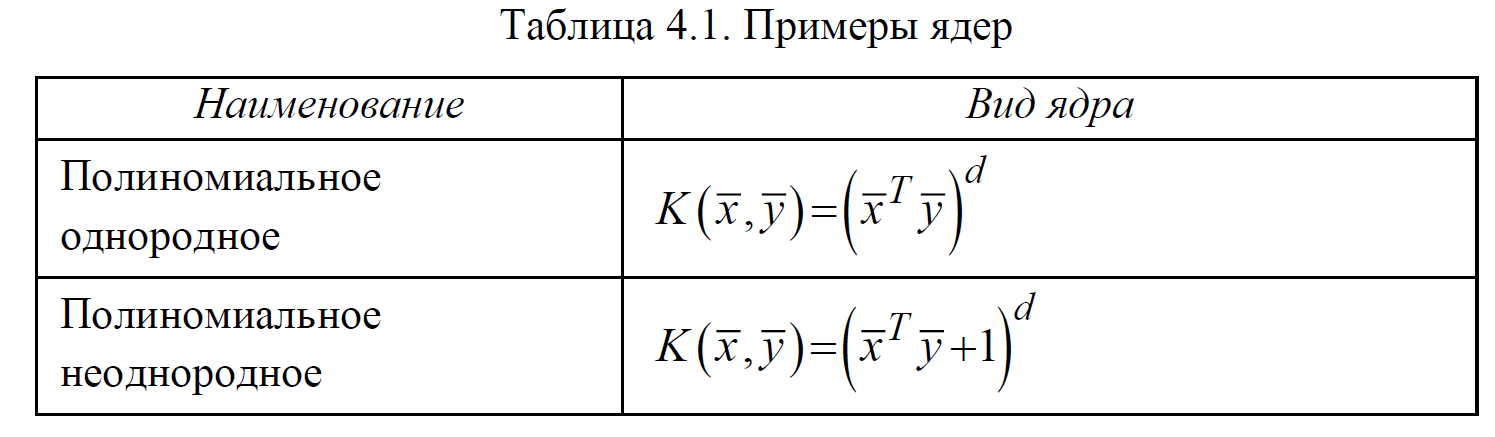
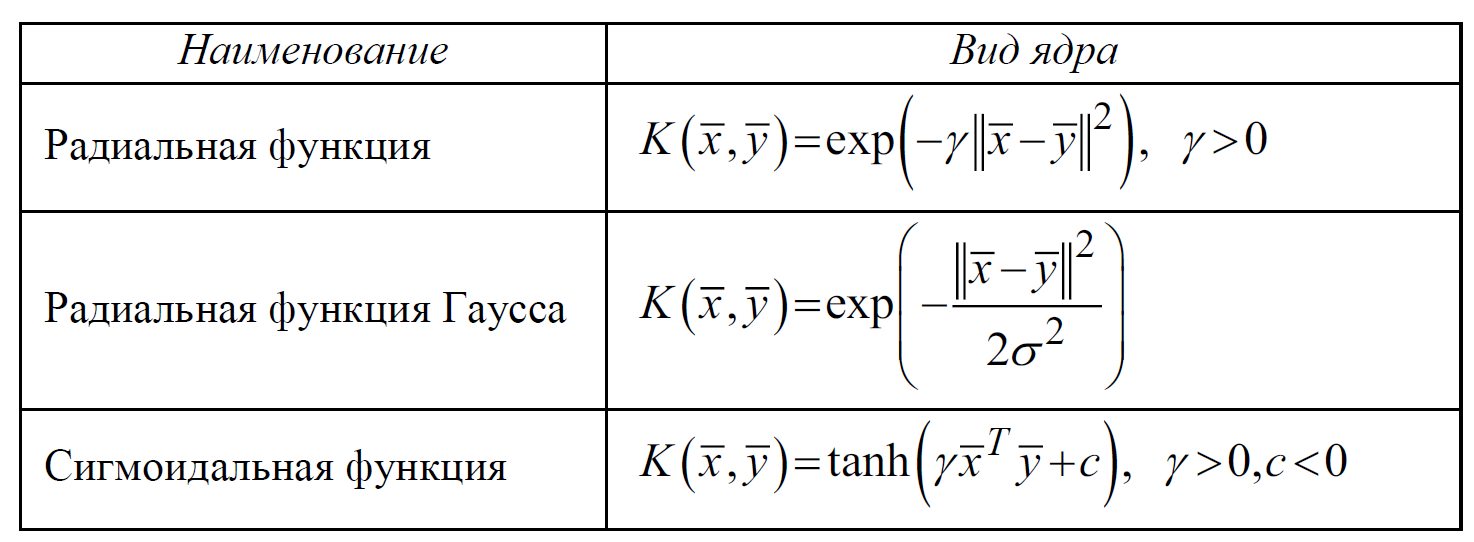

In [390]:
def get_support_vectors(X, r, C, x_min, x_max,epsilon = 1e-15, 
                        kernel = "polynomial_homo", degree = 2):    
    K = None
    if kernel == "linear":
        K = np.dot(X, X.T)
    elif kernel == "polynomial_homo":
        K = np.dot(X, X.T) ** degree    
    elif kernel == "polynomial_non-homo":
        K = (np.dot(X, X.T) + 1) ** degree
    elif kernel == "radial":
        gamma = 1.0 / X.shape[1]
        X_norm = np.sum(X**2, axis=1)
        K = np.exp(-gamma * (X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)))
    elif kernel == "gaussian_radial":
        variances = np.var(X, axis=0, ddof=1)
        sigma_sq = np.mean(variances) 
        X_norm = np.sum(X**2, axis=1)
        K = np.exp(-(X_norm[:, None] + X_norm[None, :] - 2 * np.dot(X, X.T)) / (2 * sigma_sq))
    else:
        raise ValueError(f"Неизвестное ядро: {kernel}")
    
    N = len(r)

    P = np.outer(r, r) * K    # Квадратичная часть: r_i·r_j·K(x_i,x_j)      
    q = -np.ones(N)           # Линейная часть: -∑λ_i
    G = np.vstack((-np.eye(N), np.eye(N)))  # Ограничения: 0 ≤ λ_i ≤ C
    h = np.hstack((np.zeros(N), np.full(N, C)))     # Правая часть: 0 и C         
    A = r.reshape(1, -1).astype(float)  # Ограничение равенства: ∑λ_i·r_i = 0
    b = np.array([0.0])             

    lambda_solve = solve_qp(P, q, G, h, A, b, solver="cvxopt")
    r = r.ravel()
    support_indices = (lambda_solve > epsilon)
    
    w = np.zeros(X.shape[1])
    if kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
        w = np.sum((lambda_solve * r)[:, None] * X, axis=0)
    
    marginal_sv_indices = (lambda_solve > epsilon) & (lambda_solve < C - epsilon)
    
    b = 0.0
    if np.any(marginal_sv_indices):
        X_marginal = X[marginal_sv_indices]
        r_marginal = r[marginal_sv_indices]
        
        if kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
            wx = np.dot(X_marginal, w)
            b = np.mean(r_marginal - wx)
        else:
            K_marginal = K[marginal_sv_indices][:, support_indices]
            predictions = np.dot(K_marginal, lambda_solve[support_indices] * y[support_indices])
            b = np.mean(r_marginal - predictions)
    
    if X.shape[1] == 2 and kernel in ["linear", "polynomial_homo", "polynomial_non-homo"]:
        x_line = np.linspace(x_min, x_max, 500)
        koef_a = -w[0]/w[1]
        koef_b = -b/w[1]
        luft = (1)/w[1]
        
        y_line = koef_a*x_line + koef_b
        # Верхняя граница зазора: w·x + b = +1
        y_plus  = koef_a*x_line + koef_b + luft
        # Нижняя граница зазора: w·x + b = -1
        y_minus = koef_a*x_line + koef_b - luft
        
        koefs = [koef_a, koef_b, luft]
    else:
        x_line = np.array([])
        y_line = np.array([])
        y_plus = np.array([])
        y_minus = np.array([])
        koefs = [0, 0, 0]
    
    return {
        'x': x_line, 
        'y': y_line, 
        'y_plus': y_plus, 
        'y_minus': y_minus, 
        'X_marginal': X_marginal, 
        'r_marginal': r_marginal, 
        'koefs': koefs}

In [391]:
def get_scatter(X, coef_a, coef_b, predicat):

    errors = []
    for vector in X:
        if predicat == "more":
            if coef_a * vector[0] + coef_b > vector[1]:
                errors.append(vector)
        elif predicat == "less":
            if coef_a * vector[0] + coef_b < vector[1]:
                errors.append(vector)         

    return np.array(errors)


In [395]:

C = np.array([0.1, 1, 10])

res_linear = {
    '0.1':[],
    '1':[],
    '10':[]
}
x_2 = np.concatenate((convert_x(x2_1), convert_x(x2_2)), axis=0) 
y_2 = np.hstack([np.ones(100), -np.ones(100)]).reshape(-1, 1)

error_point_linear = {
    '0.1':[],
    '1':[],
    '10':[]
}
for c in C:
    res = get_support_vectors(x_2, y_2, C[0], xlim_3[0], xlim_3[1], epsilon=0.01, kernel='linear')
    res_linear[str(c)] = res
    
    err0 = get_scatter(convert_x(x2_2), res['koefs'][0], res['koefs'][1] - res['koefs'][2], "less")
    err1 = get_scatter(convert_x(x2_1), res['koefs'][0], res['koefs'][1] + res['koefs'][2], "more")
    # print(err1)
    error_point_linear[str(c)] = [err0, err1]
    

In [396]:
res_svc = {
    '0.1':[],
    '1':[],
    '10':[]
}

for c in C:
    clf = svm.SVC(kernel="linear", C=c)
    res = get_support_vectors_SVC_universal(x_2, clf, xlim_3[0], xlim_3[1])
    res_svc[str(c)] = res

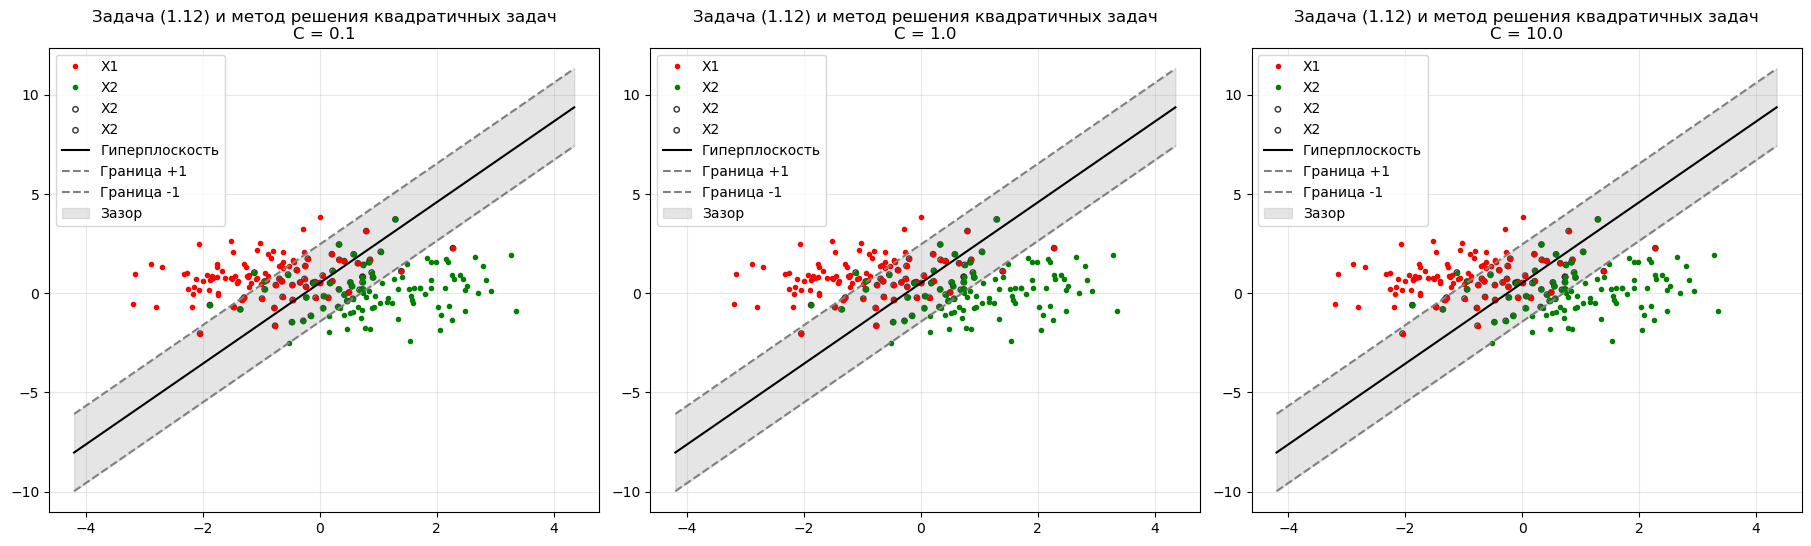

In [397]:
plt.figure(figsize=(18,10), constrained_layout=True)
i = 1
for c in C:
    pdata = res_linear[str(c)]
    errors = error_point_linear[str(c)]
    # print(errors[1][1,:])
    plt.subplot(2,3,i)
    i += 1
    plt.title(f"Задача (1.12) и метод решения квадратичных задач\nC = {c}")
    plt.plot(x2_1[0,:], x2_1[1,:], color='red', marker='.', linestyle='none', label='X1')
    plt.plot(x2_2[0,:], x2_2[1,:], color='green', marker='.', linestyle='none', label='X2')

    plt.scatter(errors[0][:,0], errors[0][:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
    plt.scatter(errors[1][:,0], errors[1][:,1], s=15, label='X2', alpha=0.8, linewidth=1, facecolors="none", edgecolors="k")
    plt.plot(pdata['x'], pdata['y'], label='Гиперплоскость', color="black")
    plt.plot(pdata['x'], pdata['y_plus'], label='Граница +1', color='gray', linestyle="--")
    plt.plot(pdata['x'], pdata['y_minus'], label='Граница -1', color='gray', linestyle="--")
    plt.fill_between(pdata['x'], pdata['y_plus'], pdata['y_minus'], color='gray', alpha=0.2, label='Зазор')
    plt.grid(True, alpha=0.3)
    plt.legend()
